#Previsione Livelli Ricoveri Terapia Intensiva, Nuovi Positivi e Deceduti per COVID

Nel seguente notebook sono stati utilizzati tre diversi modelli, LSTM, XGBoost e ARIMA con i dati resi disponibili dal Ministero della salute per effettuare un forecast con orizzonte 1, 2, 7 e 14 giorni.  

Sono stati usati i dati regionali resi disponibili via file .csv al [link](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv) e filtrati per regione di interesse, in questo caso Emilia-Romagna.
Ogni riga è un aggiornamento giornaliero dei seguenti valori): 
data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva,totale_ospedalizzati, isolamento_domiciliare, totale_positivi, variazione_totale_positivi, nuovi_positivi, dimessi_guariti, deceduti, casi_da_sospetto_diagnostico, casi_da_screening, totale_casi, tamponi, casi_testati, note, ingressi_terapia_intensiva, note_test, note_casi, totale_positivi_test_molecolare, totale_positivi_test_antigenico_rapido, tamponi_test_molecolare, tamponi_test_antigenico_rapido, codice_nuts_1, codice_nuts_2. 

Di queste sono state poi utilizzate per l'analisi: 
data, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati variazione_totale_positivi, nuovi_positivi, deceduti, 'tamponi' ingressi_terapia_intensiva.

I valori di deceduti e tamponi sono stati differenziati per avere l'incremento giornaliero invece del dato cumulativo che era presente.

L'analisi svolta è su singola variabile.

I dati sono stati divisi con percentuale di 80 e 20 rispettivamente per training e testing. 

Dopo la suddivisione è stato effettuato lo scaling attravero un MinMaxScaler che comprime i valori tra -1 ed 1 (la trasformazione viene poi invertita dopo aver fatto la previsione).

Per i modelli XGBoost e LSTM sono stati preprati i dati creando per ogni giorno un array di lag temporali e di valori futuri della variabile presa in considerazione:
(t-n,...,t-1,t) -> (t+1,...,t+p)
Questi valori sono stati utilizzati per il training dei due modelli utilizzando le variabili lag come ingresso del modello e i valori futuri come target.

Con ARIMA per ogni giorno la previsione degli n giorni successivi è stata calcolata fornendo al modello i dati presenti fino a quel momento. Il modello scelto per ARIMA è con (p,q,d) = (10,1,1)

L'errore considerato è il Mean Absolute Error sull'orizzonte di previsione. Viene poi considerata la media dei MAE calcolati su tutte le previsioni.

Gli hyperparameters sono stati scelti attraverso una grid search per ogni variabile e per ogni orizzonte temporale selezionando il modello che da una media degli errori inferiore.

Il grafico mostra lo slot temporale di previsione con MAE inferiore.


In [1]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from numpy.random import seed
import plotly.graph_objects as go

# fix for 'package not found' when installing in Anaconda environment
if 'google.colab' not in str(get_ipython()):
    import pip
    pip.main(['install', 'xgboost'])

import xgboost as xgb
from xgboost import XGBRegressor
from util import select_relevant_rows, select_attributes, read_movement_data, download_updated_mobility_data, download_updated_mobility_data, series_to_supervised, split_dates, save_config, load_config, plot_graphs


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
use_existing_config = True
column_to_predict = 'terapia_intensiva'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.80
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'
n_futures = [1, 2, 7, 14]

In [3]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

frame_interesting_columns = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

frame_interesting_columns = pd.DataFrame(frame_interesting_columns)
frame_interesting_columns['data'] = pd.to_datetime(
    frame_interesting_columns['data'])
frame_interesting_columns['data'] = frame_interesting_columns['data'].dt.strftime(
    r'%Y-%m-%d')
frame_interesting_columns = frame_interesting_columns.fillna(0)

mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

download_updated_mobility_data(
    mobility_data_url,
    file_path,
    region_mobility_path,
    mobility_data_zip_url,
    zip_path
)

mobility_df = read_movement_data(
    region_mobility_path,
    'IT_Region_Mobility_Report',
    region='Emilia-Romagna'
)

mobility_df = mobility_df[['date',
                           'retail_and_recreation_percent_change_from_baseline',
                           'grocery_and_pharmacy_percent_change_from_baseline',
                           'parks_percent_change_from_baseline',
                           'transit_stations_percent_change_from_baseline',
                           'workplaces_percent_change_from_baseline',
                           'residential_percent_change_from_baseline']].fillna(0)

frame_interesting_columns.rename(columns={'data': 'date'}, inplace=True)
frame_interesting_columns.set_index('date', inplace=True)
mobility_df.set_index('date', inplace=True)

# revert cumulative data
frame_interesting_columns['deceduti'] = frame_interesting_columns['deceduti'].diff(
)
frame_interesting_columns['tamponi'] = frame_interesting_columns['tamponi'].diff(
)
frame_interesting_columns.dropna(inplace=True)

merged = pd.merge(
    frame_interesting_columns,
    mobility_df,
    on='date'
)

merged = merged.fillna(0)
merged.set_index(pd.DatetimeIndex(merged.index), inplace=True)

# numpy seed
seed(1)

../Global_Mobility_Report.csv downloaded!
../Region_Mobility_Report_CSVs.zip downloaded!


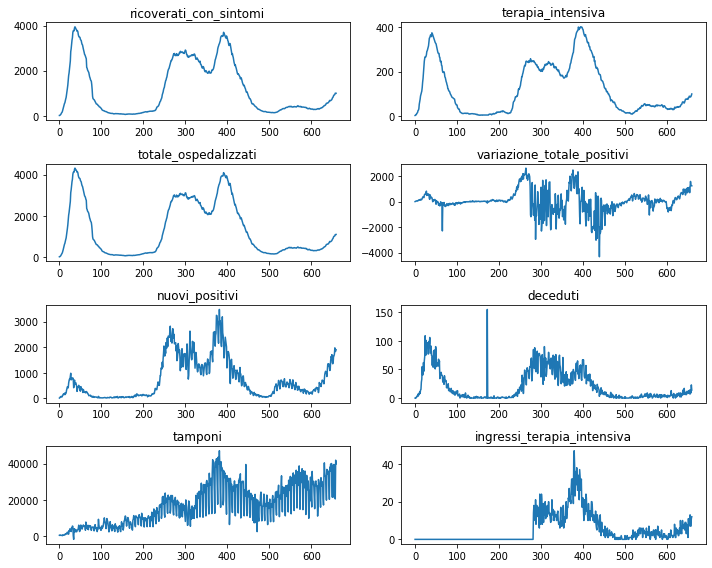

In [4]:
fig, axes = pyplot.subplots(nrows=4, ncols=2, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(
        frame_interesting_columns[frame_interesting_columns.columns[i]])
    ax.plot(pd.DataFrame(data))
    ax.set_title(frame_interesting_columns.columns[i])
    ax.plot()

pyplot.tight_layout()

In [6]:
def split_series(series, n_past, n_future, arima=False):
    X, y, X_indexes, y_indexes = list(), list(), list(), list()
    index = np.array(series.index).reshape(series.values.shape[0], 1)
    series = series.values

    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        start = 0 if arima == True else window_start

        past, future = series[start:past_end,
                              :], series[past_end:future_end, :]
        past_index, future_index = index[start:past_end,
                                         :], index[past_end:future_end, :]
        X.append(past)
        y.append(future)
        X_indexes.append(past_index)
        y_indexes.append(future_index)

    return np.array(X), np.array(y), np.array(X_indexes), np.array(y_indexes)


def plot_best_pred(
    sorted_results, column_to_predict):
        pred = sorted_results[0][1][1]['pred']
        test = sorted_results[0][1][1]['y_test']

        prediction_trace = go.Scatter(
            x=pred.index, y=pred, mode='lines', name='Prediction')
        truth_trace = go.Scatter(
            x=test.index, y=test, mode='lines', name='Ground Truth')
        layout = go.Layout(
            title=column_to_predict, xaxis={'title': 'Date'},
            yaxis={'title': column_to_predict})
        fig = go.Figure(
            data=[prediction_trace, truth_trace], layout=layout)
        fig.show()

#LSTM Multi Output 

In [7]:
def define_compile_lstm(config, input_shape, n_future=7):
    model = Sequential()
    model.add(LSTM(config['input'], activation=config['activation'],
                   input_shape=input_shape, return_sequences=True))
    model.add(LSTM(config['hidden'], activation=config['activation'],
                   return_sequences=False))
    model.add(Dropout(config['dropout']))
    model.add(Dense(n_future))
    model.compile(optimizer=config['optimizer'], loss=config['loss'])
    return model


def define_lstm_configs():
    input = [32, 64, 128]
    hidden = [32, 64, 128]
    activation = ['relu']
    dropout = [0.1, 0.2]
    out = [1]
    optimizer = ['adam']
    loss = ['mae']
    look_back = [28]

    configs = []
    keys = ['input', 'hidden', 'activation', 'dropout', 'out',
            'optimizer', 'loss', 'look_back']

    for i in input:
        for j in hidden:
            for k in activation:
                for l in dropout:
                    for m in out:
                        for n in optimizer:
                            for o in loss:
                                for p in look_back:
                                        config = dict(
                                            zip(keys, (i, j, k, l, m, n, o, p)))
                                        configs.append(config)

    return configs


def execute_lstm(
        dataframe, column_to_predict, config, split_percent=0.80, multi=False, n_future=7):
    df = dataframe[column_to_predict].copy()

    split = int(split_percent*len(df))

    n_past = config['look_back']
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

    model = define_compile_lstm(config, input_shape=(n_past,n_features), n_future=n_future)

    history = model.fit(
        X_train, y_train, epochs=50, validation_data=(X_test, y_test),
        verbose=0, shuffle=False)

    pred = model.predict(X_test)

    pred = pred.reshape(pred.shape[0], pred.shape[1], 1)

    for index, i in enumerate(train.columns):
        scaler = scalers['scaler_'+i]

        pred[:, :, index] = scaler.inverse_transform(pred[:, :, index])

        y_train[:, :, index] = scaler.inverse_transform(y_train[:, :, index])
        y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])

    df_results = []

    for i in range(len(y_test)):
        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':pred[i].reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})
        current.set_index('dates', inplace=True)
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def grid_search_lstm(
        dataframe, column_to_predict, split_percent=0.80, multi=False, n_future=7):
    configs = define_lstm_configs()
    results = []

    for config in configs:
        sorted_results = execute_lstm(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi, n_future=n_future)

        results.append((np.mean(np.array(list(map(lambda x:x[1][0], sorted_results)))), config))

    return results


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'uni_lstm_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_lstm(
                frame_interesting_columns, column_to_predict=column_to_predict,
                config=config, split_percent=split_percent, multi=False, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            results = grid_search_lstm(
                frame_interesting_columns, column_to_predict, split_percent=split_percent,
                multi=False, n_future=n_future)

            results.sort()
            config = results[0][-1]

            save_config(config_path, config)

            sorted_results = execute_lstm(
                frame_interesting_columns, column_to_predict=column_to_predict,
                config=config, split_percent=split_percent, multi=False, n_future=n_future)

        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))

        if n_future > 2:
            plot_best_pred(sorted_results, column_to_predict)
        else:
            print(('Pred: ', sorted_results[0][1][1]['pred'].values))
            print(('Test: ', sorted_results[0][1][1]['y_test'].values))


Best Config
{'input': 64, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.05258178710940342)
('Average MAE: ', 105.28719564584586)
('Pred: ', array([240.05258], dtype=float32))
('Test: ', array([240.]))
Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.1502227783203054)
('Average MAE: ', 5.159933970524715)
('Pred: ', array([34.150223], dtype=float32))
('Test: ', array([34.]))
Best Config
{'input': 128, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.1284036636352539)
('Average MAE: ', 2.7440413740965046)
('Pred: ', array([10.128404], dtype=float32))
('Test: ', array([10.]))
Best Config
{'input': 128, 'hidden': 32, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
(

Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.997958047049384)
('Average MAE: ', 7.602243537457971)


Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 5.579882213047573)
('Average MAE: ', 9.097249239596264)


Best Config
{'input': 32, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 38.5043792724609)
('Average MAE: ', 185.71448125195465)


Best Config
{'input': 128, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.5894527435302754)
('Average MAE: ', 6.743762387585601)


Best Config
{'input': 64, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.8774064949580598)
('Average MAE: ', 3.4663357715966012)


#XGBoost Multi Output

In [8]:
def define_xgb_configs():
    max_depth = [3, 6, 10]
    learning_rate = [0.01, 0.05, 0.1]
    n_estimators = [50, 100, 500, 1000]
    colsample_bytree = [0.3, 0.7]
    look_back = [28]
    objectives = ['reg:squarederror']

    configs = []
    keys = ['max_depth', 'learning_rate', 'n_estimators', 'colsample_bytree',
            'look_back', 'objective']

    for i in max_depth:
        for j in learning_rate:
            for k in n_estimators:
                for l in colsample_bytree:
                    for m in look_back:
                            for n in objectives:
                                config = dict(
                                    zip(keys, (i, j, k, l, m, n)))
                            configs.append(config)

    return configs


def execute_xgb(
        dataframe, column_to_predict, config, split_percent=0.80, n_future=7, multi=False):
    df = dataframe[column_to_predict].copy()
    split = int(split_percent*len(df))

    n_past = config['look_back']
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future)

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
    X_train_indexes = X_train_indexes.reshape(
        X_train_indexes.shape[0], X_train_indexes.shape[1])
    y_train_indexes = y_train_indexes.reshape(
        y_train_indexes.shape[0], y_train_indexes.shape[1])

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
    X_test_indexes = X_test_indexes.reshape(
        X_test_indexes.shape[0], X_test_indexes.shape[1])
    y_test_indexes = y_test_indexes.reshape(
        y_test_indexes.shape[0], y_test_indexes.shape[1])

    model = define_xgb(config)
    warnings.filterwarnings(action='ignore', category=UserWarning)
    model.fit(X_train, y_train)

    prediction = model.predict(X_test)  

    prediction[:, :] = scaler.inverse_transform(prediction[:, :])
    y_test[:, :] = scaler.inverse_transform(y_test[:, :])

    df_results = []

    for i in range(len(y_test)):
        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':prediction[i].reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})
        current.set_index('dates', inplace=True)
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def grid_search_xgb(
        dataframe, column_to_predict, split_percent=0.80, n_future=7, multi=False):
    configs = define_xgb_configs()
    results = []

    for config in configs:
        sorted_results = execute_xgb(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi, n_future=n_future)

        results.append((np.mean(np.array(list(map(lambda x:x[1][0], sorted_results)))), config))

    return results


def define_xgb(config):
    return MultiOutputRegressor(XGBRegressor(**config, verbosity=0))


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'uni_xgb_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_xgb(
                frame_interesting_columns, split_percent=split_percent, config=config,
                column_to_predict=column_to_predict, multi=False, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            results = grid_search_xgb(
                frame_interesting_columns, split_percent=split_percent,
                column_to_predict=column_to_predict, multi=False)

            results.sort(key=lambda tup: tup[0])

            config = results[0][-1]

            save_config(config_path, config)

            sorted_results = execute_xgb(
                frame_interesting_columns, split_percent=split_percent, config=config,
                column_to_predict=column_to_predict, multi=False, n_future=n_future)

        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))

        if n_future > 2:
            plot_best_pred(sorted_results, column_to_predict)
        else:
            print(('Pred: ', sorted_results[0][1][1]['pred'].values))
            print(('Test: ', sorted_results[0][1][1]['y_test'].values))


Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.3834228515625)
('Average MAE: ', 77.16948949373685)
('Pred: ', array([327.61658], dtype=float32))
('Test: ', array([328.]))
Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.07878875732421164)
('Average MAE: ', 3.3345755246969357)
('Pred: ', array([45.92121], dtype=float32))
('Test: ', array([46.]))
Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.07285308837890447)
('Average MAE: ', 3.043599502398418)
('Pred: ', array([5.927147], dtype=float32))
('Test: ', array([6.]))
Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 

Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.2880281720842623)
('Average MAE: ', 6.605269382020821)


Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.4933698517935612)
('Average MAE: ', 3.1444941898129084)


Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 35.740628923688604)
('Average MAE: ', 154.29560765815864)


Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 2.417743955339705)
('Average MAE: ', 8.708324652451735)


Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.5142677511487688)
('Average MAE: ', 3.3729657003980615)


#ARIMA Multi Output

In [9]:
split_percent = 0.80

def execute_arima(dataframe, order, column_to_predict, split_percent, n_future=7):
    df = dataframe[column_to_predict].copy()
    split = int(split_percent*len(df))

    n_past = 14
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future, arima=False)

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future, arima=False)
    
    df_results = []

    history = [x for x in train.values]

    for i in range(len(X_test)):
        current_history = np.array(history).reshape(-1)
        current_history = np.append(current_history, X_test[i].reshape(-1))

        model = ARIMA(current_history, order=order)
        model_fitted = model.fit()
        prediction = model_fitted.forecast(n_future)[0]

        prediction = scaler.inverse_transform(prediction.reshape(-1,1))
        y_test[i] = scaler.inverse_transform(y_test[i])

        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':prediction.reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})

        current.set_index('dates', inplace=True)
        
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def define_arima_configs():
    p_values = [10]
    d_values = [1]
    q_values = [1]
    return p_values, d_values, q_values


def evaluate_models(dataframe, column_to_predict, split_percent, n_future=7):
    p_values, d_values, q_values = define_arima_configs()
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                sorted_results = execute_arima(
                    dataframe, order, column_to_predict, split_percent, n_future)
                avg_error = np.mean(
                    np.array(list(map(lambda x:x[1][0], sorted_results))))
                if avg_error < best_score:
                    best_score, best_cfg = avg_error, order
    return best_cfg


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'arima_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_arima(
                frame_interesting_columns, config, column_to_predict, split_percent, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            config = evaluate_models(
                frame_interesting_columns, column_to_predict, split_percent)

            save_config(config_path, config)

            sorted_results = execute_arima(
                frame_interesting_columns, config, column_to_predict, split_percent, n_future=n_future)

        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))

        if n_future > 2:
            plot_best_pred(sorted_results, column_to_predict)
        else:
            print(('Pred: ', sorted_results[0][1][1]['pred'].values))
            print(('Test: ', sorted_results[0][1][1]['y_test'].values))


Best Config
(10, 1, 1)
('Best MAE: ', 0.4318918179872071)
('Average MAE: ', 52.64007378906129)
('Pred: ', array([458.43189182]))
('Test: ', array([458.]))
Best Config
(10, 1, 1)
('Best MAE: ', 0.0874564361686545)
('Average MAE: ', 2.183611681121151)
('Pred: ', array([29.91254356]))
('Test: ', array([30.]))
Best Config
(10, 1, 1)
('Best MAE: ', 0.051462870457682275)
('Average MAE: ', 2.3485086112978033)
('Pred: ', array([3.05146287]))
('Test: ', array([3.]))
Best Config
(10, 1, 1)
('Best MAE: ', 4.413940372572512)
('Average MAE: ', 60.20659068636831)
('Pred: ', array([163.07603568, 225.75184506]))
('Test: ', array([157., 223.]))
Best Config
(10, 1, 1)
('Best MAE: ', 0.1051866622455151)
('Average MAE: ', 2.771585222277923)
('Pred: ', array([30.14920109, 30.06117224]))
('Test: ', array([30., 30.]))
Best Config
(10, 1, 1)
('Best MAE: ', 0.24789324586314887)
('Average MAE: ', 2.3531966717602857)
('Pred: ', array([9.62736728, 9.12315377]))
('Test: ', array([10.,  9.]))
Best Config
(10, 1, 1)

Best Config
(10, 1, 1)
('Best MAE: ', 1.1106446215748116)
('Average MAE: ', 4.5689508373132535)


Best Config
(10, 1, 1)
('Best MAE: ', 0.9671572234919624)
('Average MAE: ', 2.399106400245671)


Best Config
(10, 1, 1)
('Best MAE: ', 22.52314684631919)
('Average MAE: ', 103.79827207889745)


Best Config
(10, 1, 1)
('Best MAE: ', 1.4888415466431668)
('Average MAE: ', 6.80077188765059)


Best Config
(10, 1, 1)
('Best MAE: ', 1.2228566326836359)
('Average MAE: ', 2.3829663323507377)
